In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import random
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.transforms import ToTensor, Normalize
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
import copy
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from collections import Counter

In [ ]:
data_path = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 1/data_crop'


In [ ]:
# Transform (không Augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transform (có Augmentation)
transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
original_dataset = datasets.ImageFolder(root=data_path)

class_indices = {class_idx: [] for class_idx in range(len(original_dataset.classes))}
for idx, (_, class_idx) in enumerate(original_dataset.samples):
    class_indices[class_idx].append(idx)

train_indices, test_indices = [], []

for class_idx, indices in class_indices.items():
    random.shuffle(indices)

    test_size = int(0.3 * len(indices))  #
    train_size = len(indices) - test_size

    test_class_samples = indices[:test_size]
    train_class_samples = indices[test_size:]

    test_indices.extend(test_class_samples)
    train_indices.extend(train_class_samples)

random.shuffle(train_indices)
random.shuffle(test_indices)

train_dataset = copy.deepcopy(original_dataset)
test_dataset = copy.deepcopy(original_dataset)

train_dataset.samples = [original_dataset.samples[i] for i in train_indices]
test_dataset.samples = [original_dataset.samples[i] for i in test_indices]

train_dataset.transform = transform
test_dataset.transform = transform

train_labels = [original_dataset.samples[i][1] for i in train_indices]
test_labels = [original_dataset.samples[i][1] for i in test_indices]

train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)

print(f"Tổng số mẫu trong tập train: {len(train_dataset.samples)}")
print(f"Tổng số mẫu trong tập test: {len(test_dataset.samples)}")

print("\nSố lượng mẫu trong mỗi class của tập train:")
for class_idx, count in train_class_counts.items():
    print(f"Class {class_idx}: {count} mẫu")

print("\nSố lượng mẫu trong mỗi class của tập test:")
for class_idx, count in test_class_counts.items():
    print(f"Class {class_idx}: {count} mẫu")

Tổng số mẫu trong tập train: 280
Tổng số mẫu trong tập test: 120

Số lượng mẫu trong mỗi class của tập train:
Class 1: 140 mẫu
Class 0: 140 mẫu

Số lượng mẫu trong mỗi class của tập test:
Class 1: 60 mẫu
Class 0: 60 mẫu


In [ ]:
num_augment_copies = 4  # 4x280 = 1120
aug_datasets = [copy.deepcopy(train_dataset) for _ in range(num_augment_copies)]

for aug_dataset in aug_datasets:
    aug_dataset.transform = transform_aug

dataset = ConcatDataset([train_dataset] + aug_datasets)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Tổng số ảnh train (gốc): {len(train_dataset)}, Augmented train: {len(dataset) - len(train_dataset)}, Tổng dataset: {len(dataset)}, Test: {len(test_dataset)}")

for images, labels in train_loader:
    print("Shape of images:", images.shape)
    break

Tổng số ảnh train (gốc): 280, Augmented train: 1120, Tổng dataset: 1400, Test: 120
Shape of images: torch.Size([32, 3, 224, 224])


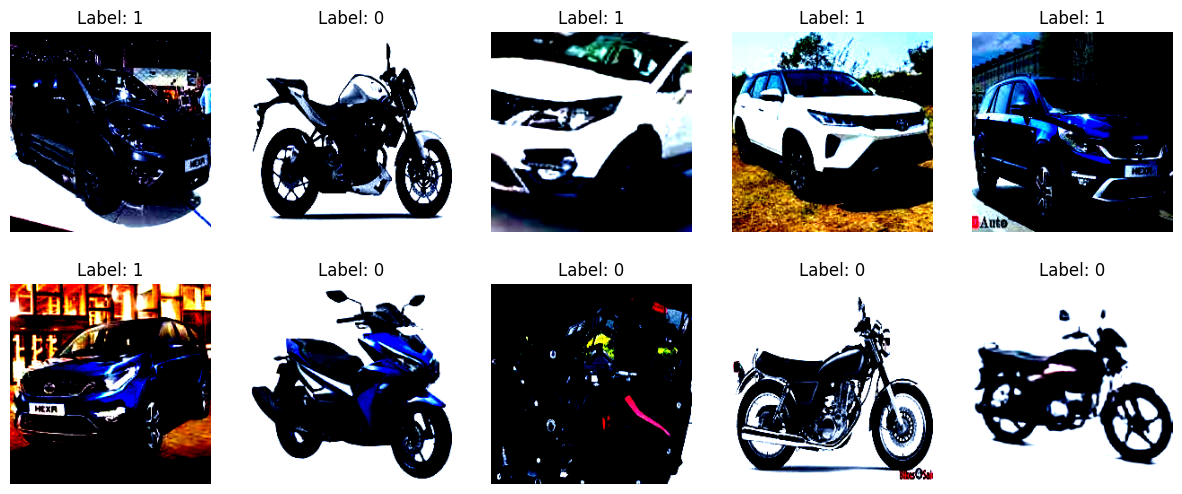

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, i in enumerate(range(100, 110)):
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax = axes[idx // 5, idx % 5]
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()

In [ ]:
# VGG16
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze feature extractor
for param in vgg16.features.parameters():
    param.requires_grad = False

num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 2)

optimizer = optim.Adam(vgg16.classifier.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()

    loss_history = []
    acc_history = []

    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix(loss=loss.item(), acc=correct / total)

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / total
        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(range(1, num_epochs+1), loss_history, color='tab:red', marker='o', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(range(1, num_epochs+1), acc_history, color='tab:blue', marker='s', linestyle='dashed', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title("Training Loss & Accuracy")
    plt.show()

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    class_names = test_loader.dataset.classes

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  # Changed line
            all_labels.extend(labels.cpu().numpy())  # Changed line

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
# prompt: sử dụng gpu để train cho code phía trên

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

vgg16 = vgg16.to(device)




Using device: cuda


Epoch 1/7: 100%|██████████| 44/44 [00:17<00:00,  2.55it/s, acc=0.536, loss=0.714]


Epoch 1/7, Loss: 0.7568, Accuracy: 0.5364


Epoch 2/7: 100%|██████████| 44/44 [00:17<00:00,  2.56it/s, acc=0.672, loss=0.59]


Epoch 2/7, Loss: 0.6114, Accuracy: 0.6721


Epoch 3/7: 100%|██████████| 44/44 [00:16<00:00,  2.63it/s, acc=0.798, loss=0.495]


Epoch 3/7, Loss: 0.5010, Accuracy: 0.7979


Epoch 4/7: 100%|██████████| 44/44 [00:16<00:00,  2.61it/s, acc=0.873, loss=0.337]


Epoch 4/7, Loss: 0.4039, Accuracy: 0.8729


Epoch 5/7: 100%|██████████| 44/44 [00:17<00:00,  2.58it/s, acc=0.908, loss=0.282]


Epoch 5/7, Loss: 0.3506, Accuracy: 0.9079


Epoch 6/7: 100%|██████████| 44/44 [00:17<00:00,  2.52it/s, acc=0.944, loss=0.272]


Epoch 6/7, Loss: 0.2815, Accuracy: 0.9436


Epoch 7/7: 100%|██████████| 44/44 [00:16<00:00,  2.59it/s, acc=0.953, loss=0.28]


Epoch 7/7, Loss: 0.2400, Accuracy: 0.9529


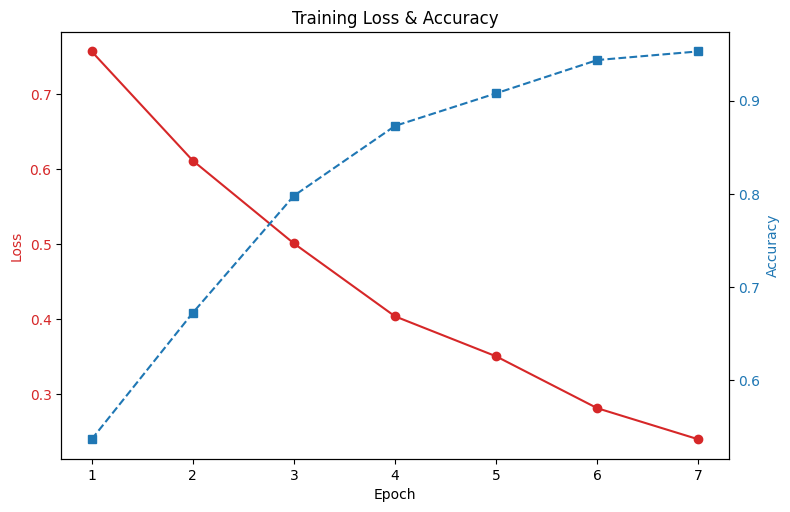

In [ ]:
train(vgg16, train_loader, criterion, optimizer, num_epochs=7)

Classification Report:
              precision    recall  f1-score   support

   Bike_Crop       1.00      0.98      0.99        60
    Car_Crop       0.98      1.00      0.99        60

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



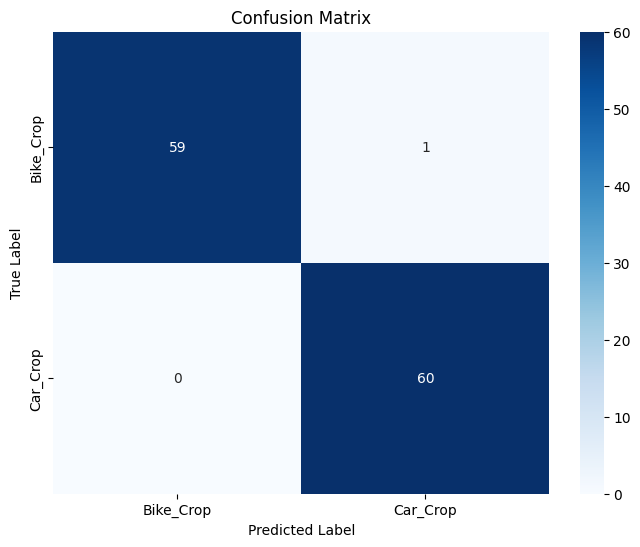

In [ ]:
evaluate_model(vgg16, test_loader)

In [ ]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze feature extractor
for param in vgg16.features.parameters():
    param.requires_grad = False

num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 2)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1